# Image Retrieval with CLIP embedding and Vector Database

## 1. Libs

In [1]:
%pip install chromadb
%pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 106.7 MB/s eta 0:00:

In [2]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

## 2. Dataset

In [3]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=e5afddb3-8399-4428-be56-9c27f99bb343
To: /content/data.zip
100% 76.1M/76.1M [00:00<00:00, 222MB/s]


In [4]:
!unzip data

Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
   creating: data/test/
   creating: data/test/American_egret/
  inflating: data/test/American_egret/n02009912_2473.JPEG  
   creating: data/test/Doberman/
  inflating: data/test/Doberman/n02107142_52285.JPEG  
   creating: data/test/Rhodesian_ridgeback/
  inflating: data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: data/test/African_crocodile/
  inflating: data/test/African_crocodile/n01697457_18534.JPEG  
   creating: data/test/Lakeland_terrier/
  inflating: data/test/Lakeland_terrier/n02095570_4644.JPEG  
   creating: data/test/ambulance/
  inflating: data/test/ambulance/n02701002_2311.JPEG  
   creating: data/test/apiary/
  inflating: data/test/apiary/n02727426_4398.JPEG  
   creating: data/test/bannister/
  inflating: data/test/bannister/n02788148_47071.JPEG  
   creating: data/test/basketball/
  inflating: data/test/basketball/n02802426_12693.JPEG  
   creating: data/test/barn_spider/
  in

In [5]:
root_dir = 'data'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
classes = sorted(list(os.listdir(train_dir)))
hnsw_space = "hnsw:space"

In [6]:
print(len(classes))


60


In [7]:
def get_image_paths(dir_path):
    image_paths = []
    for class_dir in os.listdir(dir_path):
        class_path = os.path.join(dir_path, class_dir)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
    return image_paths


In [8]:
train_image_paths = get_image_paths(train_dir)
test_image_paths = get_image_paths(test_dir)
image_paths = train_image_paths + test_image_paths


In [9]:
len(image_paths)


655

## 3. Image Embedding and Chromadb Cosine similarity Collection

In [10]:
def get_image_embedding(image_path, embedding_functions):
    image = Image.open(image_path)
    image = np.array(image)
    embedding = embedding_functions._encode_image(image)
    return embedding

In [11]:
def add_embedding_to_collection(image_paths, embedding_functions, collection):
    ids = []
    embeddings = []
    for i, image_path in enumerate(tqdm(image_paths)):
        embedding = get_image_embedding(image_path, embedding_functions)
        ids.append('id_' + str(i))
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [12]:
embedding_function = OpenCLIPEmbeddingFunction()
chroma_client = chromadb.Client()
cosine_collection = chroma_client.get_or_create_collection(name="image_collection", metadata={"hnsw:space": "cosine"})
add_embedding_to_collection(image_paths, embedding_function, cosine_collection)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 655/655 [02:07<00:00,  5.14it/s]


In [13]:
cosine_collection.count()

655

## Retrieval Example

In [23]:
def search(image_path, collection, embedding_function, n_results):
    query_embedding = get_image_embedding(image_path, embedding_function)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    return results

In [24]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

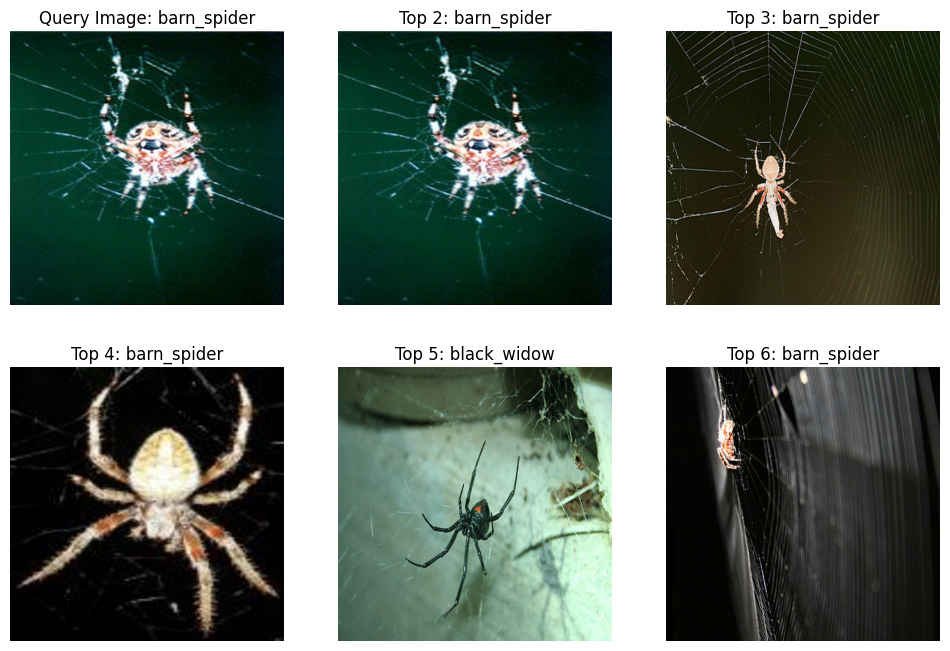

In [32]:
image_path = np.random.choice(test_image_paths)
search_results = search(image_path, cosine_collection, embedding_function, 5)
plot_results(image_path, image_paths, search_results)


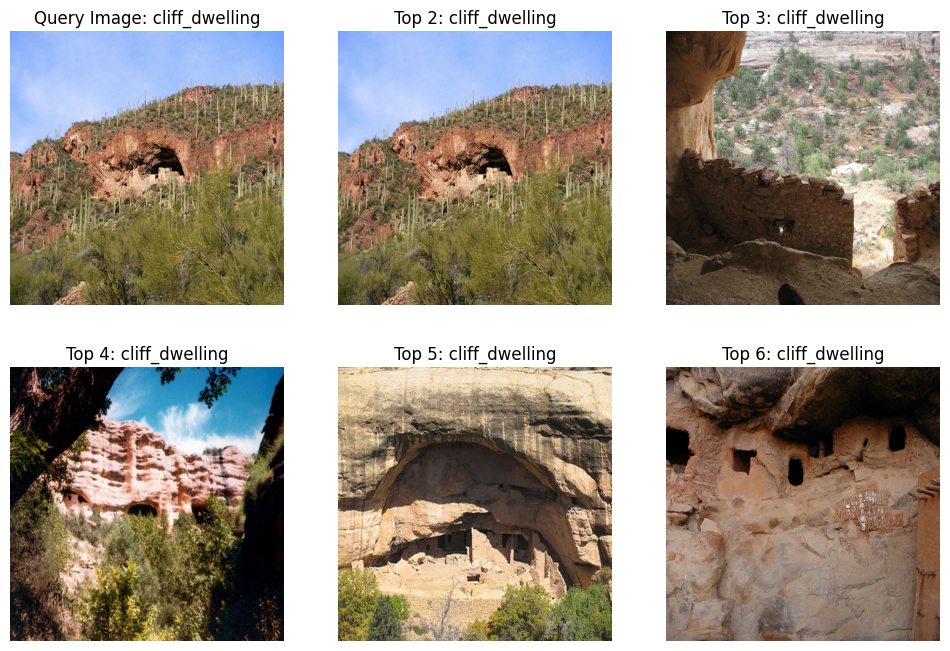